In [1]:
import sys
if '/home/cv/Dropbox/PHD/Python/ESO/spectra_DL' in sys.path:
    sys.path.remove('/home/cv/Dropbox/PHD/Python/ESO/spectra_DL')

In [2]:
import torch
from HARPS_DL.datasets.Labels import Labels

## Load Models

In [3]:
from HARPS_DL.models_structured.model_infoVAE import info_VAE as infoVAE
from HARPS_DL.models_structured.model_composite import composite_VAE
models = {}

### InfoVAE

In [4]:
labels = Labels(
            datasets_names=['ETC', 'real'],
            labels=["radvel", "BERV", "Teff", "[M/H]", "logg", "airmass", "H2O_pwv"],
            labels_type = 6*["shared"] + ["ETC"],
            bottleneck=32,
            fill_bottleneck=['ETC'],
            )
labels.json2normalization()

model = infoVAE(
        encoder_name='CNN_classic',
        decoder_name='ResNet_small',
        labels=labels,
        )
model_ckpt = '../selected_models/infoVAE/375-0.108.ckpt'
state_dict = torch.load(model_ckpt, map_location='cpu')['state_dict']
model.load_state_dict(state_dict)
model.eval()
models['infoVAE'] = {'model': model, 'labels': labels}

/tmp/ipykernel_1756993/1653281409.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_ckpt, map_location='cpu')['state_dict']


### AE (mix)

In [5]:
labels = Labels(
    datasets_names=['ETC', 'real'],
    labels=["radvel", "BERV", "Teff", "[M/H]", "logg", "airmass"],
    labels_type=6*["shared"],        
    bottleneck=9,
    fill_bottleneck=['ETC'],
)
labels.json2normalization()

model = infoVAE(
        encoder_name='CNN_classic',
        decoder_name='ResNet_small',
        labels=labels,
        bottleneck=9,
        )
model_ckpt = '../selected_models/AE (mix)/221-0.107.ckpt'
state_dict = torch.load(model_ckpt, map_location='cpu')['state_dict']
model.load_state_dict(state_dict)
model.eval()

models['AE (mix)'] = {'model': model, 'labels': labels} 

/tmp/ipykernel_1756993/479638213.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_ckpt, map_location='cpu')['state_dict']


### AE (real)

In [6]:
labels = Labels(
    datasets_names=['ETC', 'real'],
    labels=["radvel", "BERV", "Teff", "[M/H]", "logg", "airmass"],
    labels_type=6*["real"],        
    bottleneck=9,
    fill_bottleneck=['ETC'],
)
labels.json2normalization()

model = infoVAE(
        encoder_name='CNN_classic',
        decoder_name='ResNet_small',
        labels=labels,
        bottleneck=9,
        )
model_ckpt = '../selected_models/AE (real)/439-0.103.ckpt'
state_dict = torch.load(model_ckpt, map_location='cpu')['state_dict']
model.load_state_dict(state_dict)
model.eval()

models['AE (real)'] = {'model': model, 'labels': labels} 

/tmp/ipykernel_1756993/4036647572.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_ckpt, map_location='cpu')['state_dict']


- add recognition models

## Label Prediction

In [7]:
%pdb on
from astropy.io import fits
import numpy as np
from HARPS_DL.datasets.Dataset_mixin import Dataset_mixin
import pandas as pd

dp_id = 'ADP.2014-10-02T10:02:10.163'
#dp_id = 'ADP.2014-09-26T16:54:15.037'
file_name = dp_id + '.fits'
hdul = fits.open(file_name)
wave = hdul[1].data.field('WAVE').astype(np.float32).ravel() # barycentric
spectrum_fits = hdul[1].data.field('FLUX').astype(np.float32).ravel()
emul_wave = Dataset_mixin.get_wave()

spectrum = np.interp(emul_wave, wave, spectrum_fits)

labels_csv = pd.read_csv('harps_labels.csv')
labels_gt = labels_csv[labels_csv['dp_id'] == dp_id].iloc[0].to_dict()
labels_gt['name'] = 'real'
labels = models[next(iter(models))]['labels']
labels_gt = labels.dic2vec(labels_gt)
labels_gt = labels.vec2dics(labels.inverse_normalization_array(labels_gt[:labels.get_vec_length(), np.newaxis]))

Automatic pdb calling has been turned ON


Text(0.5, 1.0, 'spectrum in')

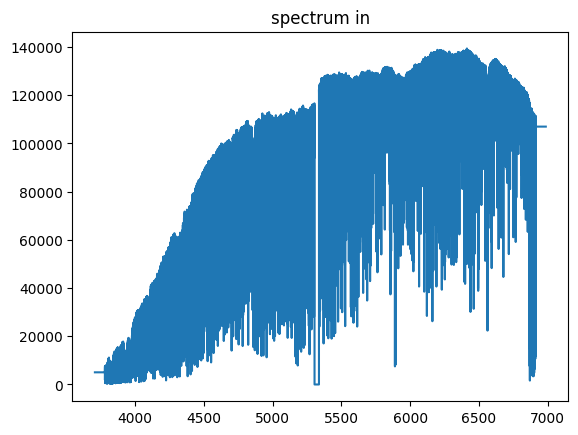

In [8]:
from matplotlib import pyplot as plt
#spectrum = Dataset_mixin.static_norm_by_median(spectrum, median_threshold=0)
plt.figure()
plt.plot(emul_wave, spectrum)
plt.title('spectrum in')

In [9]:
# Prepare spectrum for the models
spec_in = spectrum.reshape(1, 1, -1)
spec_in = spec_in/np.median(spec_in)
spec_in[:, Dataset_mixin.get_artifact_mask(1) == 0] = 0
spec_in = torch.tensor(spec_in, dtype=torch.float32)

display(labels_gt['real'])
for model_name, model in models.items():
    labels = model['labels']
    _, b_predict, _, _ = model['model'].forward(spec_in)       
    b_denorm = labels.inverse_normalization_array(b_predict.detach().numpy().T[:labels.get_vec_length(),:])
    labels_pred = labels.vec2dics(b_denorm)
    display(labels_pred['real'])

{'radvel': array([nan]),
 'BERV': array([10.44629228]),
 'Teff': array([nan]),
 '[M/H]': array([nan]),
 'logg': array([nan]),
 'airmass': array([1.268]),
 'H2O_pwv': array([nan])}

/home/cv/Dropbox/PHD/Python/ESO/standalone_share/replicated_env/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:88: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


{'radvel': array([-23.006035], dtype=float32),
 'BERV': array([9.950515], dtype=float32),
 'Teff': array([5770.465], dtype=float32),
 '[M/H]': array([0.22096173], dtype=float32),
 'logg': array([4.2686667], dtype=float32),
 'airmass': array([1.2587546], dtype=float32),
 'H2O_pwv': array([6.219159], dtype=float32)}

{'radvel': array([-22.440536], dtype=float32),
 'BERV': array([10.560535], dtype=float32),
 'Teff': array([5770.1655], dtype=float32),
 '[M/H]': array([0.22411068], dtype=float32),
 'logg': array([4.257217], dtype=float32),
 'airmass': array([1.257092], dtype=float32)}

{'radvel': array([-22.697006], dtype=float32),
 'BERV': array([10.387339], dtype=float32),
 'Teff': array([5796.79], dtype=float32),
 '[M/H]': array([0.23139024], dtype=float32),
 'logg': array([4.2718716], dtype=float32),
 'airmass': array([1.2597244], dtype=float32)}